In [17]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch as th
import torchvision
import torchvision.transforms as T

from PIL import Image
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline
from rembg.rembg import remove
from upscaler import Upscaler
upscaler = Upscaler()

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [45]:
import os
os.path.isdir("./sd- v1-5-inpainting")

False

In [53]:
def main():
    return
    print("hi")
        
if __name__ == "__main__":
    main()
    


In [2]:
model_path = "./sd-v1-5-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=th.float16,
).to(device)

In [3]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

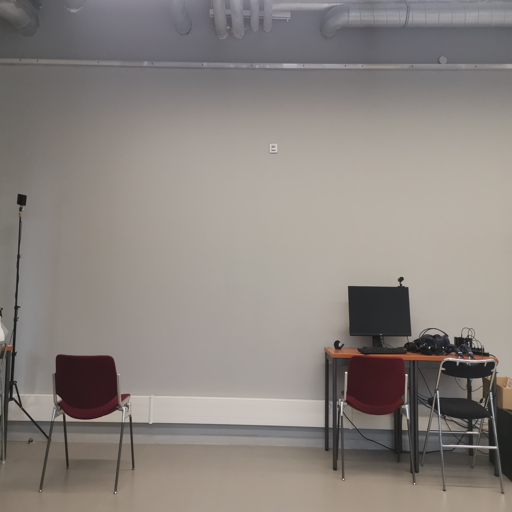

In [4]:
image = Image.open("input_images/0.png").resize((512, 512))
image

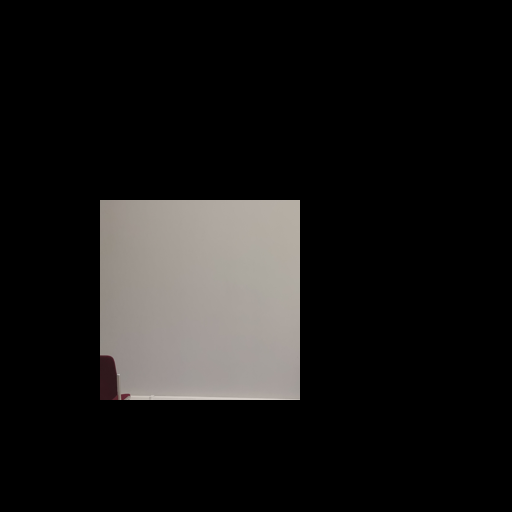

In [5]:
to_image = T.ToPILImage()
to_tensor = T.PILToTensor()

posX, posY = 200, 300
size = 200

x1, x2 = int(posX-(size/2)), int(posX+(size/2))
y1, y2 = int(posY-(size/2)), int(posY+(size/2))
source_mask_512 = th.zeros(size=(512,512))
source_mask_512[y1:y2, x1:x2] = 1
source_mask_512.size()
source_mask_512 = source_mask_512 * to_tensor(image)*255
mask_image = to_image(source_mask_512)
mask_image 

In [30]:
prompt = "a window towards the mountains"

guidance_scale=7.5
num_samples = 1
generator = th.Generator(device=device).manual_seed(42) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


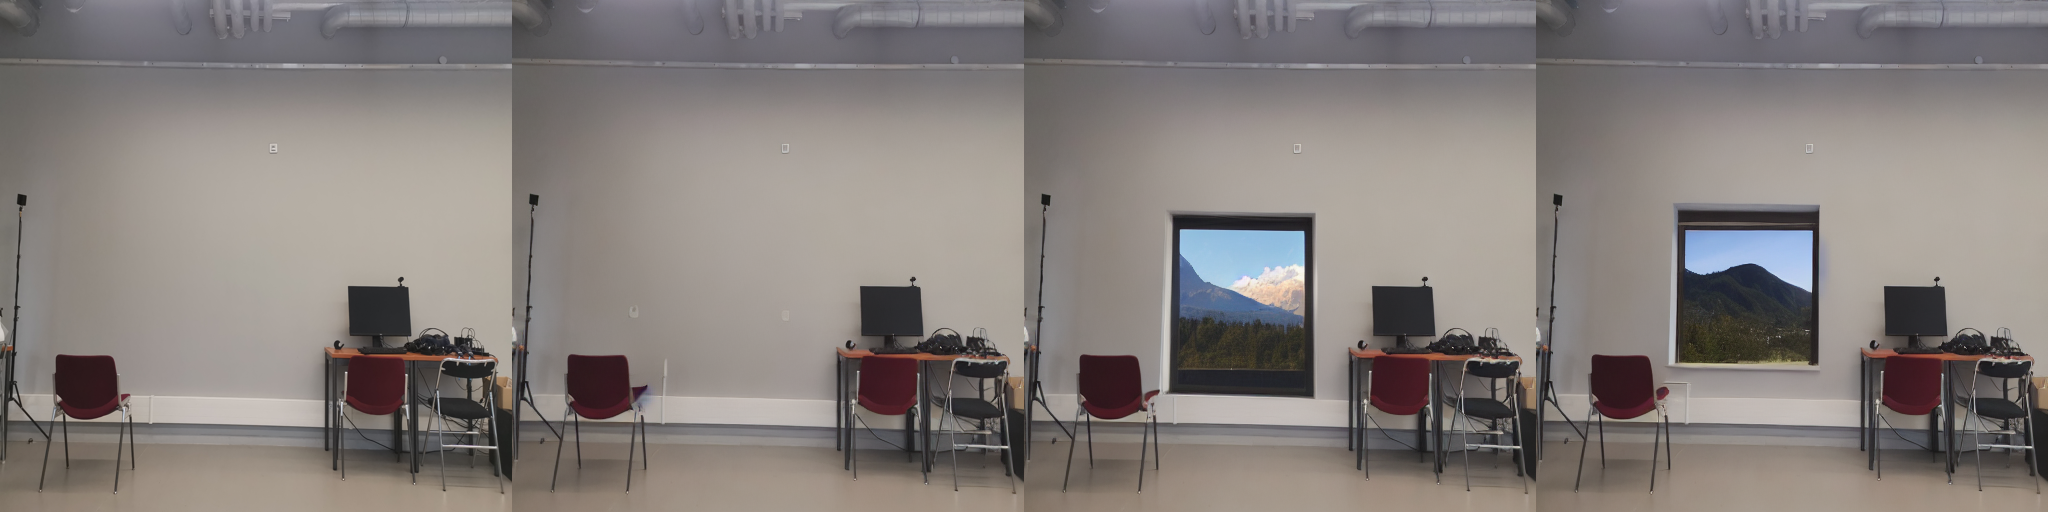

In [31]:
list_images = images.copy()
list_images.insert(0, image)
image_grid(list_images, 1, len(list_images))

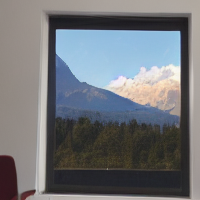

In [34]:
generated_parts = [to_image(to_tensor(img)[:, y1:y2, x1:x2]) for img in images]
generated_part = generated_parts[1]
generated_part

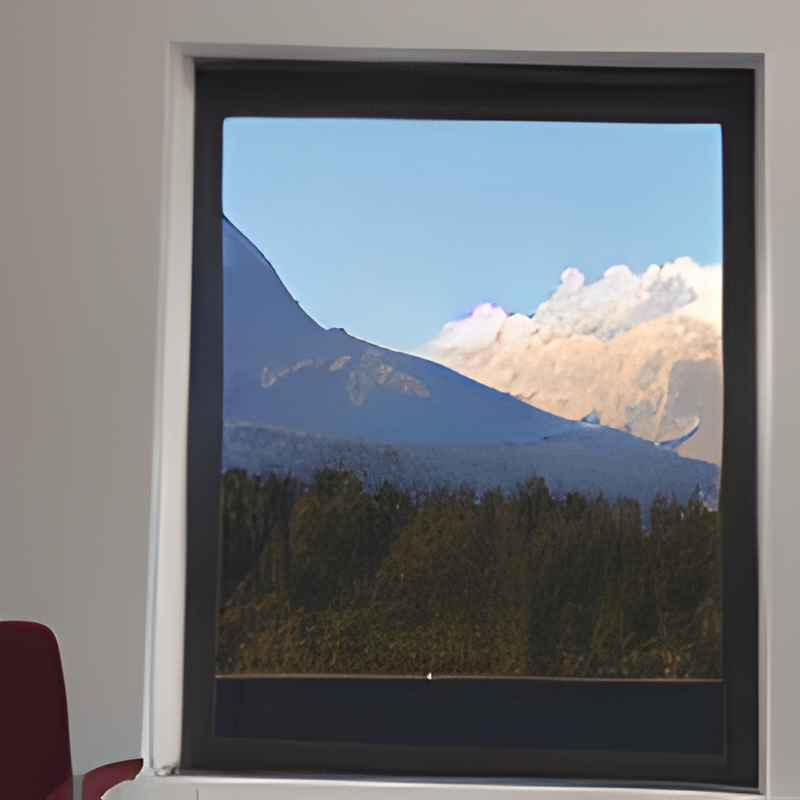

In [35]:
upscaled_part = upscaler.upscale(generated_part)
upscaled_part

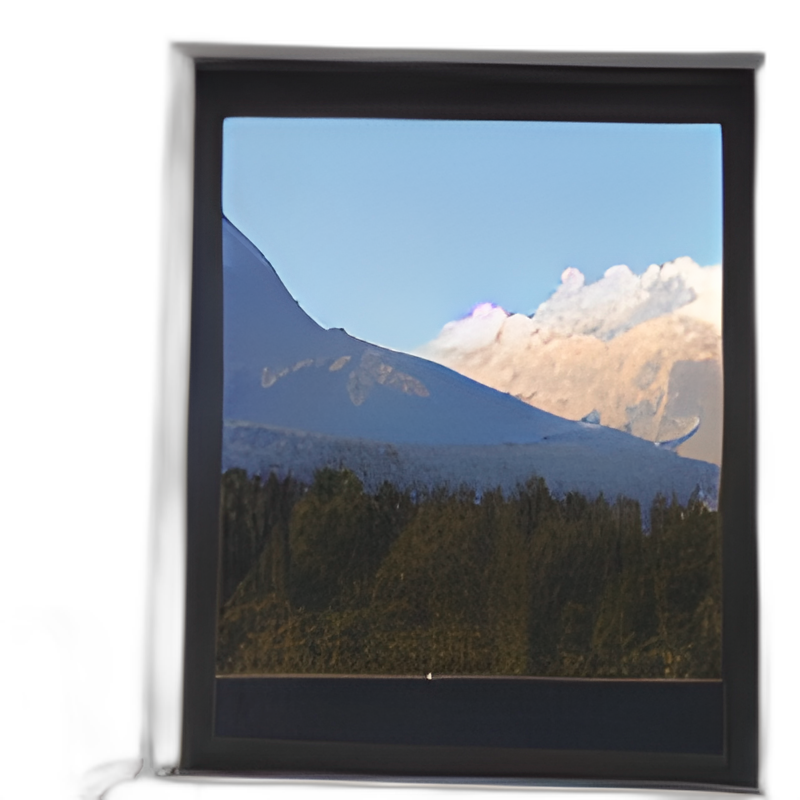

In [36]:
extracted_part = remove(upscaled_part)
extracted_part